# Project 8 - Stock Price Prediction - Training LSTM model
### Using ***LSTM*** 
### Train/Validation/Test R2 score : **99.32%**, **93.71%**, **45.65%** 

- Course Name :         Applied Machine Learning
- Course instructor:    Sohail Tehranipour
- Student Name :        Afshin Masoudi Ashtiani
- Project 8 :           Stock Price Prediction
- Date :                September 2024
- Files :               2/2

## Step 1 : Install required libraries



In [119]:
%pip install numpy pandas
%pip install matplotlib seaborn plotly
%pip install scikit-learn keras 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Step 2 : Import required libraries

In [120]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras import Sequential, layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Suppress warnings
warnings.filterwarnings("ignore")

## Step 3 : Load and prepare the dataset (Stock Price)

- Load the dataset

In [121]:
# Load dataset
data_dir = r'C:/Users/Afshin/Desktop/10_Projects/Project_8_Apple_Stock_Price_Prediction/datasets'
# data_path = '/content/drive/My Drive/Applied Machine Learning/Project 8 : Stock Price Prediction/datasets'
stock_name = 'Google'
ticker = 'GOOG'

stock_data = pd.read_csv(os.path.join(data_dir, f'{ticker}_stock_data.csv'))
stock_data.info()
stock_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2516 non-null   object 
 1   Open    2516 non-null   float64
 2   High    2516 non-null   float64
 3   Low     2516 non-null   float64
 4   Close   2516 non-null   float64
dtypes: float64(4), object(1)
memory usage: 98.4+ KB


,Date,Open,High,Low,Close
1483,2020-11-20,86.797623,87.109497,88.699997,87.093002
717,2017-11-06,51.111351,51.294998,51.743500,51.250000
1085,2019-04-26,63.381264,63.609001,63.653500,63.015999
1311,2020-03-19,55.564850,55.764500,57.898499,53.005402
2445,2024-09-20,164.453430,164.639999,164.750000,163.179993


- Convert 'Date' to datetime format

In [122]:
# Convert 'Date' to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Open    2516 non-null   float64       
 2   High    2516 non-null   float64       
 3   Low     2516 non-null   float64       
 4   Close   2516 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 98.4 KB


## Step 4 : Exploratory Data Analysis (EDA)

In [123]:
def plot_stock_price_data(data: pd.DataFrame, stock_name: str=None) -> None:
    """Plot historical stock price data including Open, High, Low, and Close prices."""

    # Extract necessary columns
    dates = data['Date']
    open_prices = data['Open']
    high_prices = data['High']
    low_prices = data['Low']
    close_prices = data['Close']

    # Create a plotly graph object
    fig = go.Figure()

    # Add traces for Open, High, Low, and Close prices
    fig.add_trace(go.Scatter(x=dates, y=open_prices, mode='lines', name='Open Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=dates, y=high_prices, mode='lines', name='High Price', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=dates, y=low_prices, mode='lines', name='Low Price', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=dates, y=close_prices, mode='lines', name='Close Price', line=dict(color='orange')))

    # Add titles and labels
    fig.update_layout(
        title=f'{stock_name} Historical Stock Prices',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        template='plotly',
        xaxis_rangeslider_visible=True
    )
    # Show the plot
    fig.show()

In [124]:
# Assuming you have a DataFrame `stock_data` with columns 'Date', 'Open', 'High', 'Low', 'Close'

plot_stock_price_data(stock_data, stock_name)

## Step 5 : Split the dataset into the Train and Test data

- Drop irrequired features

In [125]:
target_col = 'Open'
stock_data = stock_data[['Date', target_col]]
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Open    2516 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


In [126]:
def split_data(data: pd.DataFrame, target_col: str, test_size: float = 0.1):
    """Split the dataset into training and testing sets."""
    train_size = int(len(data) * (1 - test_size))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size + 1:]
    
    train_features = train_data['Date'].values.reshape(-1, 1)
    train_targets = train_data[target_col].values.reshape(-1, 1)
    test_features = test_data['Date'].values.reshape(-1, 1)
    test_targets = test_data[target_col].values.reshape(-1, 1)

    print(f'> Shape of       Dataset : {data.shape}')
    print(f'> Shape of Train Dataset : {train_data.shape}')
    print(f'> Shape of Train Feature : {train_features.shape}')
    print(f'> Shape of Train Target  : {train_targets.shape}')
    print(f'> Shape of Test  Dataset : {test_data.shape}')
    print(f'> Shape of Test  Feature : {test_features.shape}')
    print(f'> Shape of Test  Target  : {test_targets.shape}')
    
    return (
        train_data, np.array(train_features), np.array(train_targets),
        test_data, np.array(test_features), np.array(test_targets)
    )

In [127]:
# Split the data
test_size = 1 / 30
train_data, train_features, train_targets, test_data, test_features, test_targets = split_data(stock_data, target_col, test_size)

> Shape of       Dataset : (2516, 2)
> Shape of Train Dataset : (2432, 2)
> Shape of Train Feature : (2432, 1)
> Shape of Train Target  : (2432, 1)
> Shape of Test  Dataset : (83, 2)
> Shape of Test  Feature : (83, 1)
> Shape of Test  Target  : (83, 1)


## Step 6 : Preprocessing data

- Scale targets 

In [128]:
# Scale targets
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_targets = scaler.fit_transform(train_targets)
scaled_test_targets = scaler.transform(test_targets)

- Generate a dataset using **Sliding window** method

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs40095-014-0105-5/MediaObjects/40095_2014_105_Fig2_HTML.gif?as=webp">

<img src="https://www.researchgate.net/publication/350876716/figure/fig5/AS:1012722275729412@1618463214081/Sliding-window-approach-for-time-series-data.png">

In [129]:
def create_sliding_window_dataset(X: np.ndarray, y: np.ndarray, window_size: int):
    """Generate features and labels using a sliding window approach."""
    if window_size >= len(X):
        raise ValueError("Window size must be less than the length of the dataset.")

    features, labels = [], []
    for i in range(window_size, len(X)):
        features.append(y[i-window_size:i])
        labels.append(y[i])

    return np.array(features), np.array(labels)

In [130]:
# Generate sliding window dataset
window_size = 60
X_train, y_train = create_sliding_window_dataset(train_features, scaled_train_targets, window_size)
X_test, y_test = create_sliding_window_dataset(test_features, scaled_test_targets, window_size)

# Print the sizes of the generated dataset
print(f'> Number of Train Samples  : {len(train_data)}')
print(f'> Shape  of Train Features : {len(X_train)}')
print(f'> Shape  of Train Labels   : {len(y_train)}')
print(f'> Number of Test  Samples  : {len(test_data)}')
print(f'> Shape  of Test  Features : {len(X_test)}')
print(f'> Shape  of Test  Labels   : {len(y_test)}')

> Number of Train Samples  : 2432
> Shape  of Train Features : 2372
> Shape  of Train Labels   : 2372
> Number of Test  Samples  : 83
> Shape  of Test  Features : 23
> Shape  of Test  Labels   : 23


## Step 7 : Build, compile and fit a LSTM model

- Create and compile an LSTM model

In [131]:
def build_lstm_model(input_shape: tuple, n_layers: int = 3, units: int = 128, dropout: float = 0.2, lr: float = 0.001) -> Sequential:
    """Build and compile an LSTM model."""
    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    
    for _ in range(n_layers):
        model.add(layers.LSTM(units, return_sequences=True if _ < n_layers - 1 else False))
        model.add(layers.Dropout(dropout))
    
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=['r2_score'])

    # Summary the model
    model.summary()

    return model

In [132]:
# Set parameters
input_shape = X_train.shape[1:]
n_layers = 3
units = 128
dropout_rate = 0.2
learning_rate = 0.001

# Create the LSTM model
lstm_model = build_lstm_model(input_shape=X_train.shape[1:])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,857 (1.26 MB)

 Trainable params: 329,857 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

- Fit the LSTM model

In [133]:
# Parameters
epochs = 200
batch_size = 64
split_rate = 0.1

# model_dir = r'C:/Users/Afshin/Desktop/10_Projects/Project_8_Apple_Stock_Price_Prediction/models'
# model_dir = '/content/drive/My Drive/Applied Machine Learning/Project 8 : Stock Price Prediction/models'
# best_model_path = os.path.join(model_dir,'best_LSTM_model.keras')
# Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model
lstm_history = lstm_model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=split_rate, 
    # callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 338ms/step - loss: 0.0320 - r2_score: 0.3076 - val_loss: 0.0016 - val_r2_score: 0.8608
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - loss: 0.0014 - r2_score: 0.9671 - val_loss: 0.0026 - val_r2_score: 0.7763
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - loss: 0.0011 - r2_score: 0.9749 - val_loss: 0.0014 - val_r2_score: 0.8748
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - loss: 9.6946e-04 - r2_score: 0.9772 - val_loss: 0.0030 - val_r2_score: 0.7415
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - loss: 9.7219e-04 - r2_score: 0.9772 - val_loss: 0.0020 - val_r2_score: 0.8246
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - loss: 8.8345e-04 - r2_score: 0.9802 - val_loss: 0.0016 - val_r2_score: 0.8588
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - loss: 9.2424e-04 - r2_score: 0.9790 - val_loss: 0.0026 - val_r2_score: 0.7727
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - loss: 9.2786e-04 -

- Display the training history

In [134]:
def plot_history(history=None, stock_name: str = None, figure_directory: str = None, ylim_pad=[0, 0], figsize=(10, 10), show_grid=True):
    """Plot the training history of loss and R2 score with dual y-axes."""

    if history is None:
        raise ValueError(f"The {stock_name}-history object must be provided.")

    x_labels = 'Epoch'

    # Creating a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=figsize)

    metrics = ['loss', 'r2_score']
    titles = ['Train', 'Validation']

    for i, title in enumerate(titles):
        # Prepare data
        y1 = history.history[metrics[0]] if title == 'Train' else history.history['val_loss']
        y2 = history.history[metrics[1]] if title == 'Train' else history.history['val_r2_score']

        ax1 = axs[i]
        
        # Plotting the loss
        ax1.plot(y1, label=f'{title} Loss', color='tab:blue')
        ax1.set_xlabel(x_labels)
        ax1.set_ylabel('Loss', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.set_title(f'{title} Loss and R2 Score per Epoch')
        ax1.legend(loc='lower left')
        
        # Create a second y-axis for the R² score
        ax2 = ax1.twinx()
        ax2.plot(y2, label=f'{title} R2 Score', color='tab:red')
        ax2.set_ylabel('R2 Score', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper left')

        # Optional ylim padding
        if ylim_pad:
            ax1.set_ylim([min(y1) - ylim_pad[0], max(y1) + ylim_pad[1]])
            ax2.set_ylim([min(y2) - ylim_pad[0], max(y2) + ylim_pad[1]])

        if show_grid:
            ax1.grid()

    fig.tight_layout()  # Adjust subplots to fit into figure area.

    if figure_directory:
        plt.savefig(f"{figure_directory}/{stock_name}_training_history.png")  # Save to directory

    plt.show()

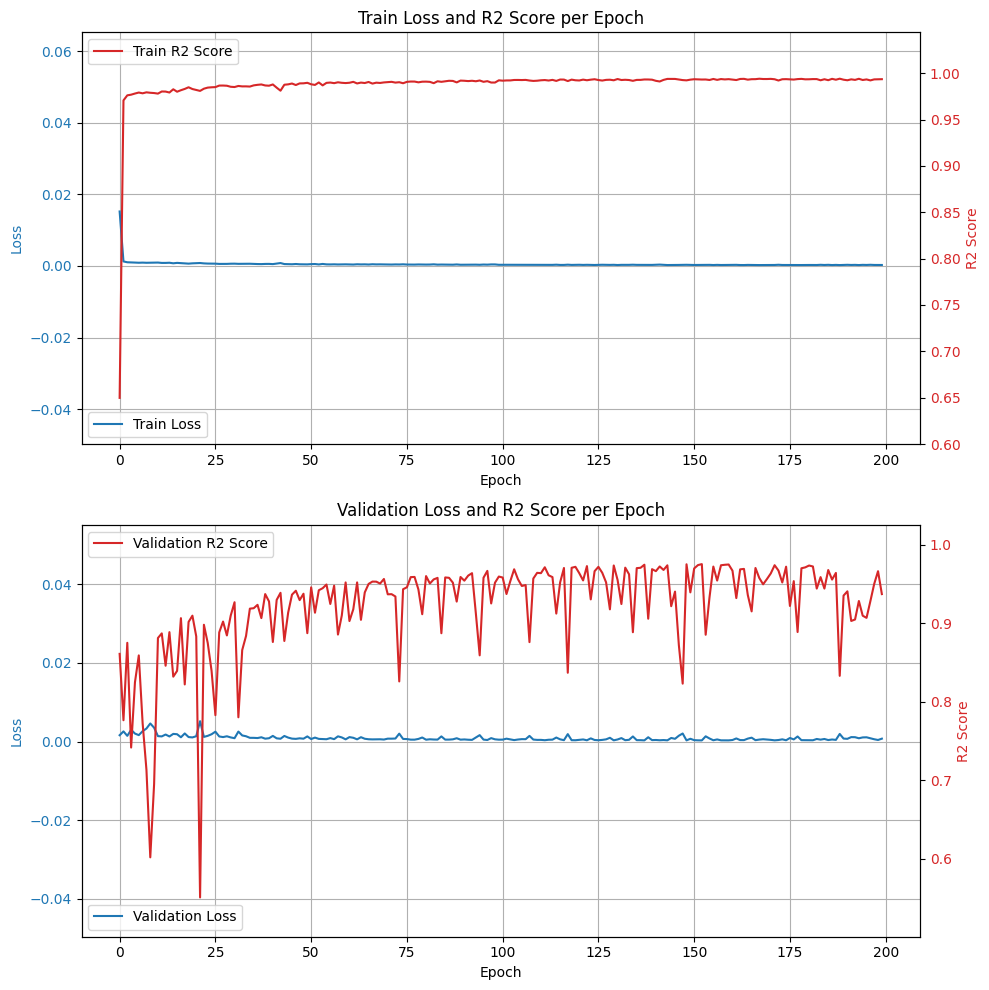

In [135]:
# Assuming you have the history object from the model training
figure_dir = r'C:/Users/Afshin/Desktop/10_Projects/Project_8_Apple_Stock_Price_Prediction/plots'
# figure_dir = '/content/drive/My Drive/Applied Machine Learning/Project 8 : Stock Price Prediction/plots'
# figure_dir = '/kaggle/working'

plot_history(history=lstm_history, stock_name=stock_name, figure_directory=figure_dir, ylim_pad=[0.05, 0.05], figsize=(10, 10))

## Step 8 : Predict and Evaluate the LSTM model

In [136]:
# Evaluate and predict
test_loss, test_r2_score = lstm_model.evaluate(X_test, y_test)
y_test_pred = lstm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

print(f'>> Test Evaluations  : ')
print(f'> Evaluated Loss     : {test_loss:.4f}')
print(f'> Evaluated R2 Score : {test_r2_score * 100:.2f}')
print(f'> R2 Score           : {r2 * 100:.2f}')
print(f'> RMSE               : {rmse:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0027 - r2_score: 0.2255
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
>> Test Evaluations  : 
> Evaluated Loss     : 0.0027
> Evaluated R2 Score : 22.55
> R2 Score           : 22.55
> RMSE               : 0.0522


## Step 9 : Display test predictions

In [137]:
def display_prediction(targets, targets_pred, stock_name: str = None, figure_directory: str = None):    

    plt.figure(figsize=(10,6))
    plt.plot(targets, color='blue', label=f'Actual {stock_name} Stock Price')
    plt.plot(targets_pred , color='red', label=f'Predicted {stock_name} Stock Price')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{stock_name} Stock Price')
    plt.legend()
    plt.grid()

    if figure_directory:
        plt.savefig(f"{figure_directory}/{stock_name}_stock_price_prediction.png")  # Save to directory

    plt.show()

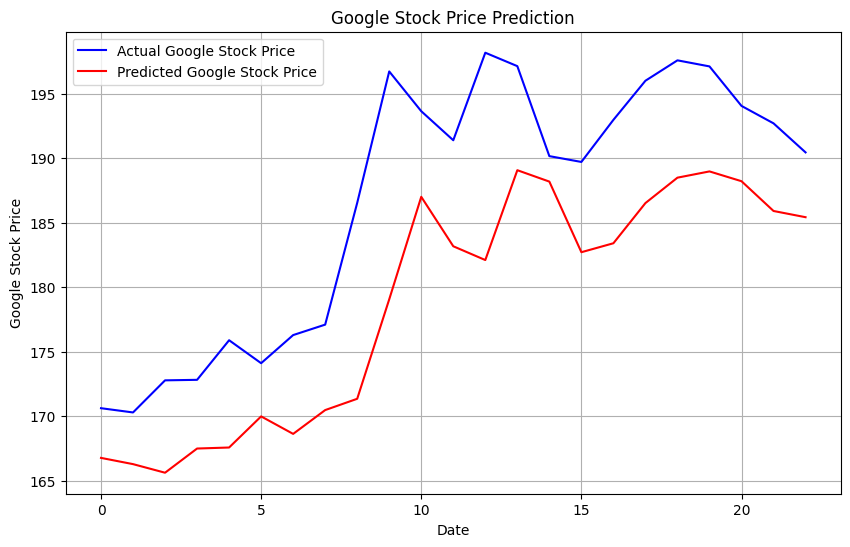

In [138]:
# Invert scaling for predictions
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

display_prediction(y_test, y_test_pred, stock_name, figure_dir)

## Step 10 : Save the LSTM model

In [139]:
model_dir = r'C:/Users/Afshin/Desktop/10_Projects/Project_8_Apple_Stock_Price_Prediction/models'
# model_dir = '/content/drive/My Drive/Applied Machine Learning/Project 8 : Stock Price Prediction/models'
model_path = os.path.join(model_dir ,f'{stock_name}_LSTM_model.keras')

lstm_model.save(model_path)
print(f'> LSTM model saved to {model_path}')

> LSTM model saved to C:/Users/Afshin/Desktop/10_Projects/Project_8_Apple_Stock_Price_Prediction/models\Google_LSTM_model.keras
